# TMDB Box Office Prediction

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%matplotlib inline

In [545]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA

import ast
import time
import json

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [7]:
train_data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

## Data Description

In [8]:
train_data.shape

(3000, 23)

In [9]:
train_data.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [11]:
train_data.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [72]:
test_data.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

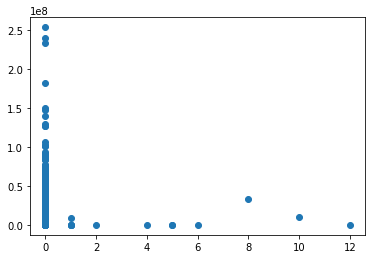

In [754]:
mask = train_data['budget'] < 50
plt.scatter(train_data[mask]['budget'], train_data[mask]['revenue'])

In [753]:
[(f'budget < {x}', np.sum(train_data['budget'] < x)) for x in [5, 50, 500, 5000, 50000, 100000, 500000, 1000000]]

[('budget < 5', 819),
 ('budget < 50', 825),
 ('budget < 500', 829),
 ('budget < 5000', 831),
 ('budget < 50000', 843),
 ('budget < 100000', 849),
 ('budget < 500000', 901),
 ('budget < 1000000', 968)]

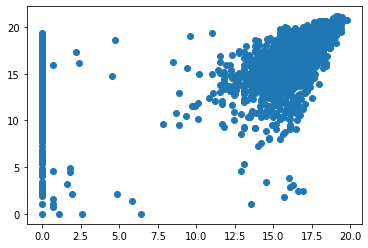

In [132]:
plt.scatter(np.log(1+train_data['budget']), np.log(train_data['revenue']))

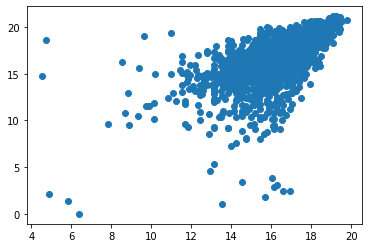

In [755]:
plt.scatter(np.log(1+train_data[~mask]['budget']), np.log(train_data[~mask]['revenue']))

## Feature Exploration and Engineering

- id: no relation to revenue
- belongs_to_collection: useful for sequels, prequels, remakes. but how to encode it?
    - use collection_id with OHE, if null set it to 'original'
- budget: use as it is / log transform?
- genres: use id, how to encode multivalue attributes?
    - create as many columns as there are unique ids, if a movie belongs to a genre, its column is set to 1
    - what happens during test time? - unseen genre? - ignore it
    - quickly increases the feature space dimensionality - use dimensionality reduction?
        - use dimensionality reduction on just genres or on all features?
        - there is not much correlation between genres, dimensionality reduction isn't effective - prove this
- homepage: has homepage or not?
- imdb_id: not relevant - see if any null? if it doesn't have an IMDB page, not a very popular movie
- original_language - OHE
- original_title - how to encode text? n - grams? - embedding?
- overview - how to encode text?
- popularity: numerical
- poster_path: how to use images?
- production_companies: use the same approach as genres
- production_countries: use the same approach as genres
- release date: split into date, month, year
- runtime: numerical
- spoken_languages: use the same approach as genres
- status: OHE
- tagline: how to encode text
    - presence
- title: how to encode text
- keywords: use the same approach as genres
- cast: ??
- crew: ??
- revenue: log transform?

### Numerical Attributes

Questions to ask while exploring the data:
- are there any missing values?
- is the data cut-off or transformed to exist in a min and max values?
- is the distribution skewed? - why is this a problem?
    - very few datapoints have very high / low values - so what?

Numerical:
- budget
    - there are movies with budget 0; 826 movies with below budget of 100 - what to do?; bad data; most likely that testing data will have the same problem.
    - right skewed; use log1p transformation
    - what are the units? (same units for films filmed outside US?)
    - test set have 1211 values with budget = 0 and 1245 with budget <= 500
    - either estimate budget from fields or develope two models one where budget has a meaningful value and other model without the budget feature
- popularity
    - how is it measured / interpretted?
    - what is its intended scale?
    - has outliers - valid or noise from data measurement?
- month
    - December has the highest number of releases
- year
    - follows yy convention. hard to distinguish a yy such that 00<=yy<=18 if it belongs to 1900-1918 or 2000-2018?
    - if yy > 17, assume 19yy, esle 20yy
- day of the month
- day of the week
- runtime
    - has 2 null values; replace with median
    - has 12 zero values; replace with median
- revenue
    - right skewed
    - min is 1
    - what are the units?
    - 39 movies with revenue below 100; bad data; most likely that testing data will have the same problem.
    
    
What to do when data has obvious issues like measurement errors, but you know the test set has the same problems?
- can't drop the entire rows because you can't do that with test set
- remove feature? - use cv
- replace it with a mean / median value if it is numerical, or a new category if it is a categorical

#### budget, revenue, popularity, runtime

<AxesSubplot:>

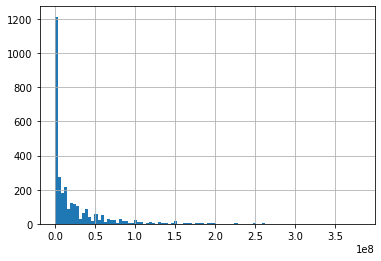

In [12]:
train_data['budget'].hist(bins=100)

In [577]:
(train_data['budget']<=500).sum()

829

In [576]:
(test_data['budget']<=500).sum()

1245

<AxesSubplot:>

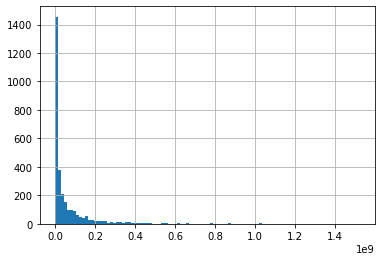

In [14]:
train_data['revenue'].hist(bins=100)

In [15]:
(train_data['revenue']<100).sum()

39

<AxesSubplot:>

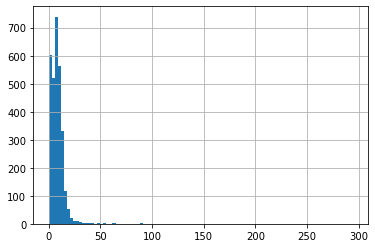

In [16]:
train_data['popularity'].hist(bins=100)

<AxesSubplot:>

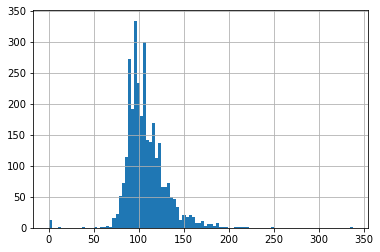

In [17]:
train_data['runtime'].hist(bins=100)

In [47]:
train_data[(train_data['runtime']==0)].shape

(12, 23)

In [65]:
runtime_imputer = make_pipeline(SimpleImputer(strategy='median'), SimpleImputer(missing_values=0, strategy='median'), 'passthrough')
runtime_tf = runtime_imputer.fit_transform(train_data[['runtime']])
stats.describe(runtime_tf)

DescribeResult(nobs=3000, minmax=(array([11.]), array([338.])), mean=array([108.27]), variance=array([440.83604535]), skewness=array([1.66653171]), kurtosis=array([7.75439472]))

#### release_date

In [19]:
yy = train_data['release_date'].apply(lambda s: int(s.split('/')[2]))
(yy == 17).sum(), (yy == 18).sum(), (yy == 19).sum(), (yy == 20).sum(), (yy == 21).sum()

(40, 0, 0, 0, 1)

In [20]:
def year_convertor(s):
    yy = int(s.split('/')[2])
    if yy > 17:
        return 1900+yy
    else:
        return 2000+yy

release_year = train_data['release_date'].apply(year_convertor)
release_month = train_data['release_date'].apply(lambda s: int(s.split('/')[0]))
release_day = train_data['release_date'].apply(lambda s: int(s.split('/')[1]))

<AxesSubplot:>

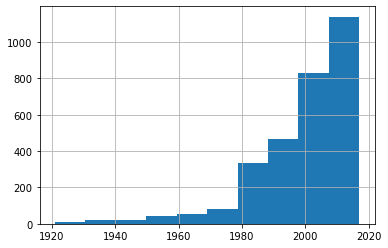

In [21]:
release_year.hist()

<AxesSubplot:>

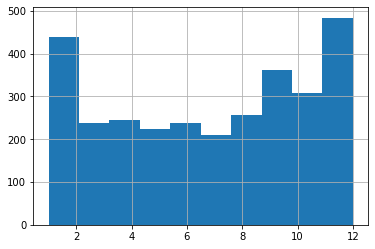

In [22]:
release_month.hist()

<AxesSubplot:>

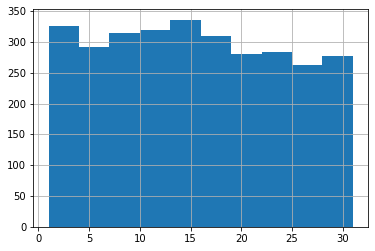

In [23]:
release_day.hist()

In [29]:
import datetime

# d = datetime.strptime('2/20/2021', '%m/%d/%Y')

d = datetime.date(2021, 11, 10)
d.weekday()

2

In [110]:
class ReleaseDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        def year_convertor(s):
            yy = int(s.split('/')[2])
            if yy > 17:
                return 1900+yy
            else:
                return 2000+yy
            
        def day_of_week_convertor(s):
            year = year_convertor(s)
            month = int(s.split('/')[0])
            day = int(s.split('/')[1])
            
            return datetime.date(year, month, day).weekday() # Monday is 0
        
        release_date = pd.Series(X.reshape(-1,))
        release_year = release_date.apply(year_convertor)
        release_month = release_date.apply(lambda s: int(s.split('/')[1]))
        release_day_of_week = release_date.apply(day_of_week_convertor)
        
        release_year.name = 'release_year'
        release_month.name = 'release_month'
        release_day_of_week.name = 'release_day_of_week'
        
        return pd.concat([release_year, release_month, release_day_of_week], axis=1)
    
t = ReleaseDateTransformer()
release_date_transformed = t.fit_transform(train_data['release_date'].values)

array([[<AxesSubplot:title={'center':'release_year'}>,
        <AxesSubplot:title={'center':'release_month'}>],
       [<AxesSubplot:title={'center':'release_day_of_week'}>,
        <AxesSubplot:>]], dtype=object)

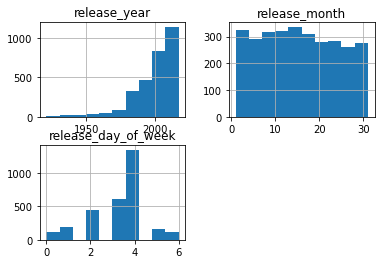

In [108]:
release_date_transformed.hist()

In [44]:
release_date_transformed['release_day_of_week'].value_counts()

4    1348
3     615
2     449
1     190
5     161
0     124
6     113
Name: release_day_of_week, dtype: int64

Most releases are on Friday

#### Cast and Crew

In [961]:
cast_ex = train_data['cast'].iloc[0]
len(ast.literal_eval(cast_ex))

24

In [980]:
mask = train_data['cast'].isna()
cast_size = train_data[~mask]['cast'].apply(lambda text: len(ast.literal_eval(text)))
cast_size.describe()

count    2987.000000
mean       20.693338
std        16.610013
min         0.000000
25%        11.000000
50%        16.000000
75%        24.000000
max       156.000000
Name: cast, dtype: float64

In [981]:
mask = train_data['crew'].isna()
crew_size = train_data[~mask]['crew'].apply(lambda text: len(ast.literal_eval(text)))
crew_size.describe()

count    2984.000000
mean       24.496314
std        28.084650
min         1.000000
25%         8.000000
50%        15.000000
75%        29.000000
max       194.000000
Name: crew, dtype: float64

(<AxesSubplot:>, <AxesSubplot:>)

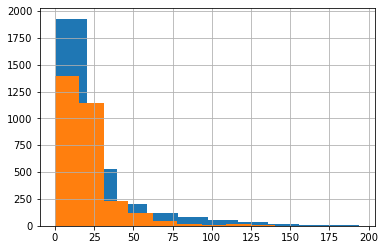

In [991]:
crew_size.hist(), cast_size.hist()

In [1003]:
class AttributeCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.Series(X.reshape(-1,)).apply(lambda text: len(ast.literal_eval(text))).values.reshape(-1, 1)
    
act = make_pipeline(SimpleImputer(strategy='constant', fill_value='[]'), AttributeCountTransformer(), SimpleImputer(strategy='median', missing_values=0))
act.fit_transform(train_data[['cast']].values)

array([[24.],
       [20.],
       [51.],
       ...,
       [15.],
       [26.],
       [34.]])

### Categorical Features

#### original_language and status

In [ ]:
train_data[['original_language']].value_counts()

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(train_data[['original_language']])

enc.categories_

In [ ]:
train_data[['status']].value_counts()

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(train_data[['status']])

enc.categories_

#### genres, production_companies, production_countries, spoken_languages, and Keywords

In [374]:
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name'])
    return L

genres = train_data[train_data['genres'].notna()]['genres'].apply(convert)

# train_data[train_data['production_companies'].notna()]['production_companies'].apply(convert)
production_countries = train_data[train_data['production_countries'].notna()]['production_countries'].apply(convert)
# train_data[train_data['spoken_languages'].notna()]['spoken_languages'].apply(convert)
# train_data[train_data['Keywords'].notna()]['Keywords'].apply(convert)

In [445]:
train_data.iloc[470]

id                                                                     471
belongs_to_collection                                                  NaN
budget                                                             2000000
genres                                                                 NaN
homepage                                                               NaN
imdb_id                                                          tt0349159
original_language                                                       en
original_title             The Book of Mormon Movie, Volume 1: The Journey
overview                 The story of Lehi and his wife Sariah and thei...
popularity                                                        0.079856
poster_path                               /rJnEmqJDMu4aYfALVCcPrjqIDaK.jpg
production_companies                                                   NaN
production_countries                                                   NaN
release_date             

In [455]:
genre_set = set()
for gList in genres.values:
    genre_set.update(set(gList))
genre_map = dict(zip(sorted(genre_set), range(len(genre_set))))

arr = np.zeros((1, 20))
x = genres.values[1]

idx = list(map(lambda g: genre_map[g], x))

arr[0, idx] = 1
arr

array([[0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.]])

In [507]:
set(['a', 'b', 'c']) & set()

{'a'}

In [510]:
class MultinomialAttributeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories_ = []
        pass
    def fit(self, X, y=None):
        self.attr_set = set()
        for attrList in X:
            self.attr_set.update(set(attrList))
        self.attr_cardinality = len(self.attr_set)
        
        self.categories_ = [s.replace(' ', '_') for s in sorted(self.attr_set)]
        
        self.attr_idx_map = dict(zip(self.categories_, range(self.attr_cardinality)))
        return self
    def transform(self, X):
        arr = np.zeros((X.shape[0], self.attr_cardinality))
        
        for i, attrList in enumerate(X):
            idx = list(map(lambda attr: self.attr_idx_map[attr.replace(' ', '_')], set(attrList)&self.attr_set))
            arr[i, idx] = 1
            
        return arr
    
mat = MultinomialAttributeTransformer()
mat.fit_transform(genres.values), mat.categories_

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.]]),
 ['Action',
  'Adventure',
  'Animation',
  'Comedy',
  'Crime',
  'Documentary',
  'Drama',
  'Family',
  'Fantasy',
  'Foreign',
  'History',
  'Horror',
  'Music',
  'Mystery',
  'Romance',
  'Science_Fiction',
  'TV_Movie',
  'Thriller',
  'War',
  'Western'])

In [411]:
class ExtractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.Series(X.reshape(-1,)).apply(convert)
    
ext = ExtractionTransformer()
ext.fit_transform(train_data[train_data['genres'].notna()]['genres'].values).shape

(2993,)

In [465]:
mat_imp = SimpleImputer(strategy='constant', fill_value='[]')
mat_pipe = make_pipeline(mat_imp, ExtractionTransformer(), MultinomialAttributeTransformer())
genres_tsf = mat_pipe.fit_transform(train_data[['genres']])
genres_tsf[470]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

##### Keywords Dimensionality Reduction

In [557]:
keywords_pipe = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer(), 
        MultinomialAttributeTransformer(),
        PCA(n_components=100)
    )
keywords_tsf = keywords_pipe.fit_transform(train_data[['Keywords']])
keywords_tsf.shape

(3000, 100)

In [560]:
sum(keywords_pipe.named_steps['pca'].explained_variance_ratio_)

0.26535779341191496

In [547]:
pca = PCA()
pca.fit(keywords_tsf)

PCA()

In [555]:
np.cumsum(pca.explained_variance_ratio_)[100]

0.2682089904388687

<BarContainer object of 30 artists>

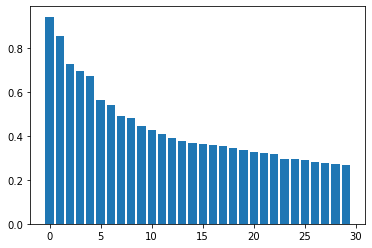

In [556]:
n=30
plt.figure()
plt.bar(range(n), 100*pca.explained_variance_ratio_[:n])

## Conditional Predictor

In [769]:
class ConditionalPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, pipelineA=None, pipelineB=None, make_mask=None, thresh=None):
        self.pipelineA = pipelineA
        self.pipelineB = pipelineB
        self.make_mask = make_mask
        self.thresh = thresh
    def fit(self, X, y=None):
        mask = self.make_mask(X, self.thresh)
        self.pipelineA.fit(X[mask], y[mask])
        self.pipelineB.fit(X[~mask], y[~mask])
        return self
    def predict(self, X):
        mask = self.make_mask(X, self.thresh)
        y_pred_a = self.pipelineA.predict(X[mask])
        y_pred_b = self.pipelineB.predict(X[~mask])
        
        y = np.zeros_like(np.hstack((y_pred_a, y_pred_b)))
        y[mask] = y_pred_a
        y[~mask] = y_pred_b
        
        return y

In [770]:
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

def make_mask(X, thresh=500):
    return X['budget'] < thresh

In [771]:
def common_config():
    return [
    ('popularity', make_pipeline(
        SimpleImputer(strategy='median'), 
        StandardScaler()
    ), ['popularity']),
    
    ('runtime', make_pipeline(
        RuntimeImputer, 
        StandardScaler()
    ), ['runtime']),
    
    ('release_date', make_pipeline(
        SimpleImputer(strategy='most_frequent'), 
        ReleaseDateTransformer()
    ), ['release_date'])
]

prep_pipeline_A = ColumnTransformer(common_config(), remainder='drop')

prep_pipeline_B = ColumnTransformer([
    ('budget', make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log1p),
        StandardScaler()
    ), ['budget'])] + 
    
    common_config()
    , remainder='drop')

full_pipeline_A = make_pipeline(prep_pipeline_A, Ridge())
full_pipeline_B = make_pipeline(prep_pipeline_B, Ridge())

cond_pipeline = ConditionalPredictor(full_pipeline_A, full_pipeline_B, make_mask, 50)

cond_pipeline.fit(X_train, y_train)

ConditionalPredictor(make_mask=<function make_mask at 0x28c43c940>,
                     pipelineA=Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('popularity',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='median')),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 ['popularity']),
                                                                                ('runtime',
                                                                                 Pipeline(steps

In [772]:
y_pred = cond_pipeline.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

2.249930048302935

## Baseline Estimator

pipeline

- budget, popularity: median imputer and standard scaler
- runtime: runtime_imputer and standard scaler
- release_date: release_date_transformer, OHE on month and weekday, standard scaler on year
- original_language and status: OHE

In [1033]:
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 22), (600, 22), (2400,), (600,))

In [1031]:
RuntimeImputer = make_pipeline(SimpleImputer(strategy='median'), SimpleImputer(missing_values=0, strategy='median'))

def MAET():
    return make_pipeline(
        SimpleImputer(strategy='constant', fill_value='[]'), 
        ExtractionTransformer(), 
        MultinomialAttributeTransformer()
    )

def make_attribute_count_pipeline():
    return make_pipeline(
            SimpleImputer(strategy='constant', fill_value='[]'), 
            AttributeCountTransformer(), 
            SimpleImputer(strategy='median', missing_values=0),
            StandardScaler()
    )

KEYWORDS_DIM = 100

multinomial_attributes = ['cast', 'crew', 'production_companies', 'production_countries', 'spoken_languages']


def make_prep_pipeline(include_budget = True):
    budget_config = [('budget', make_pipeline(
            SimpleImputer(strategy='median'),
            FunctionTransformer(np.log1p),
            StandardScaler()
        ), ['budget'])]
    
    config = [
        ('popularity', make_pipeline(
            SimpleImputer(strategy='median'), 
            StandardScaler()
        ), ['popularity']),

        ('runtime', make_pipeline(
            RuntimeImputer, 
            StandardScaler()
        ), ['runtime']),

        ('release_date', make_pipeline(
            SimpleImputer(strategy='most_frequent'), 
            ReleaseDateTransformer()
        ), ['release_date']),

        ('original_language and status', make_pipeline(
            SimpleImputer(strategy='most_frequent'), 
            OneHotEncoder(handle_unknown='ignore')
        ), ['original_language', 'status']),

        ('genres', MAET(), ['genres']),

#         ('production_companies', MAET(), ['production_companies']),
        
#         ('production_countries', MAET(), ['production_countries']),

#         ('spoken_languages', MAET(), ['spoken_languages']),

        ('Keywords', make_pipeline(
            SimpleImputer(strategy='constant', fill_value='[]'), 
            ExtractionTransformer(), 
            MultinomialAttributeTransformer(),
            PCA(n_components = KEYWORDS_DIM)
        ), ['Keywords']),
        
        ('cast_counts', make_attribute_count_pipeline(), ['cast']),
        ('crew_counts', make_attribute_count_pipeline(), ['crew']),
        ('production_companies_counts', make_attribute_count_pipeline(), ['production_companies']),
        ('production_countries_counts', make_attribute_count_pipeline(), ['production_countries']),
        ('spoken_languages_counts', make_attribute_count_pipeline(), ['spoken_languages'])
    ]
    
    if include_budget:
        config = budget_config + config
    
    return ColumnTransformer(config, remainder='drop')

def make_full_cond_pipeline(predictorA, predictorB):
    full_pipeline_A = make_pipeline(make_prep_pipeline(include_budget=False), predictorA)
    full_pipeline_B = make_pipeline(make_prep_pipeline(), predictorB)

    return ConditionalPredictor(full_pipeline_A, full_pipeline_B, make_mask, 500)

full_cond_pipeline = make_full_cond_pipeline(Ridge(), Ridge())

In [1032]:
def get_features(prep_pipeline, budget=True):
    x = prep_pipeline.named_transformers_['original_language and status'].named_steps['onehotencoder'].categories_
    genres_ft = prep_pipeline.named_transformers_['genres'].named_steps['multinomialattributetransformer'].categories_
    # production_companies_ft = prep_pipeline.named_transformers_['production_companies'].named_steps['multinomialattributetransformer'].categories_
    # production_countries_ft = prep_pipeline.named_transformers_['production_countries'].named_steps['multinomialattributetransformer'].categories_
    # spoken_langauges_ft = prep_pipeline.named_transformers_['spoken_languages'].named_steps['multinomialattributetransformer'].categories_
    # keywords_ft = prep_pipeline.named_transformers_['Keywords'].named_steps['multinomialattributetransformer'].categories_
    keywords_ft = map(str, range(KEYWORDS_DIM))
    counts = [f'{attr}_counts' for attr in multinomial_attributes]
# ['comp_'+f for f in production_companies_ft] + \
# ['pc_'+f for f in production_countries_ft] + \
# ['sl_'+f for f in spoken_langauges_ft] + \
    features = ['popularity', 'runtime', 'release_year', 'release_month', 'release_DOW'] + \
                list(x[0]) + list(x[1]) + \
                ['genre_'+f for f in genres_ft] +\
                ['kw_'+f for f in keywords_ft] + \
                counts
    if budget:
        features = ['budget'] + features
    return features

prep_pipeline = make_prep_pipeline()
X_train_tsf = prep_pipeline.fit_transform(X_train)

features = get_features(prep_pipeline)

data_tsf = pd.DataFrame(X_train_tsf, columns=features)
data_tsf.shape

(2400, 168)

In [1034]:
full_cond_pipeline.fit(X_train, y_train)
y_pred = full_cond_pipeline.predict(X_test)
rmsle = mean_squared_error(y_test, y_pred, squared=False)
rmsle

2.3072637778498875

In [1035]:
train_error = mean_squared_error(y_train, full_cond_pipeline.predict(X_train), squared=False)
train_error

2.013197917508092

In [1036]:
results = pd.DataFrame(columns=["ExpID", "Train Score", "CV Score", "Test Score", "Train Time(s)", "Test Time(s)"])
results.loc[0] = ["Baseline_Cond_Ridge", "---", np.round(train_error, 5), np.round(rmsle, 5), "---", "---"]
results

,ExpID,Train Score,CV Score,Test Score,Train Time(s),Test Time(s)
0,Baseline_Cond_Ridge,---,2.0132,2.30726,---,---


In [714]:
def kaggle_submission(name, model, X, y, test_data, submissions_filename, output_location):
    model.fit(X, y)
    y_pred = model.predict(test_data)
    
    subs = pd.read_csv(submissions_filename)
    subs['revenue'] = np.exp(y_pred)
    
    output_filename = output_location + '/' + name + '.csv'
    subs.to_csv(output_filename, index=False)
    
    print(f'kaggle competitions submit -c tmdb-box-office-prediction -f {output_filename} -m "{name}"')

In [715]:
kaggle_submission('baseline_cond_Ridge', full_cond_pipeline, X, y, test_data, 'data/sample_submission.csv', 'predictions')

kaggle competitions submit -c tmdb-box-office-prediction -f predictions/baseline_cond_Ridge.csv -m "baseline_cond_Ridge"


## Grid Search over Variety of Algorithms

In [614]:
def log_random(a, b, n):
    loga, logb = np.log(a), np.log(b)
    x = loga + (logb-loga)*np.random.random(n)
    y = np.exp(x)
    return y

def log_linear(a, b, n):
    loga, logb = np.log(a), np.log(b)
    x = np.linspace(loga, logb, n)
    return np.exp(x)
    
# sorted(np.round(log_random(0.01, 10, 10), 5)), sorted(np.round(log_linear(0.1, 10, 10), 5))

### Search for Pipeline with budget (>500)

In [939]:
def conductGridSearch(models, params_grid, prep_pipeline, scoring, 
                      X_train, y_train, X_test, y_test, 
                      results, prefix='', i=0, n_jobs=4, verbose=1):
    i = 0
    for (name, model) in models:
        i += 1
        # Print model and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid.get(name, {})
        print("Parameters:")
        if 'features' in param_grid:
            for p in sorted(params_grid['features']):
                print("\t"+str(p)+": "+ str(params_grid['features'][p]))
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
            ("preparation", prep_pipeline),
            ("predictor", model)
        ])
        
        # Execute the grid search
        params = params_grid.get('features', {})
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring=scoring, cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
        
        
        best_train_score = -1*np.round(scoring(grid_search.best_estimator_, X_train, y_train), 5)
        
        # Best estimator score
        best_cv_score = -1*np.round(grid_search.best_score_, 5)

        # Best estimator fitting time
        start = time.time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time.time() - start, 4)

        # Best estimator prediction time
        start = time.time()
        best_test_score = -1*np.round(scoring(grid_search.best_estimator_, X_test, y_test), 5)
        test_time = round(time.time() - start, 4)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_score, best_cv_score, best_test_score, train_time, test_time]

        
from sklearn.neural_network import MLPRegressor   
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
        
models = [
    # ('Ridge', Ridge(alpha=26)),
    # ('ExtraTreesRegressor', ExtraTreesRegressor()),
    # ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=11, weights='distance', p=2)),
    ('RandomForestRegressor', RandomForestRegressor(max_depth=40, min_samples_leaf=10, n_jobs=4, random_state=1000))
]

param_grid = {
    # 'features': {
    #     'preparation__Keywords__pca__n_components': [30, 100, 300]
    # },
    # 'Ridge': {
    #     'alpha': range(24, 34, 2) #log_linear(25, 100, 10) # 26
    # },
    # 'KNeighborsRegressor': {
    #     'n_neighbors': np.arange(3,30,2), # 11
    #     'weights': ['uniform', 'distance'], # distance
    #     'p': [1, 2] # 2
    # }
    'RandomForestRegressor': {
            # 'max_depth': np.arange(25, 60, 5), #40
            # 'max_features': ["auto", "sqrt", "log2"], #auto
            # 'min_samples_split': [2,4,5,6], # 2
            # 'min_samples_leaf': [5, 10, 15], # 10
            # 'bootstrap': [True, False], # True which is the default
            'n_estimators':[100, 200, 300] # 100
    },
    'ExtraTreesRegressor': {
            # 'max_depth': list(range(10, 20)), #16
            # 'max_features': ["auto", "sqrt", "log2"], #auto
            # 'min_samples_split': range(40, 52, 2), # 47, 48
            # 'min_samples_leaf': [1, 5, 7, 10, 12, 14, 16], # 10
            # 'bootstrap': [True, False], # True which is the default
            # 'n_estimators':[100, 200, 300], # 200
    }
}

root_mean_squared_error = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

prep_pipeline = make_prep_pipeline()

mask = train_data['budget'] > 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

conductGridSearch(models, param_grid, prep_pipeline, root_mean_squared_error, 
                 X_train, y_train, X_test, y_test,
                 results)
results

(1736, 22) (435, 22) (1736,) (435,)
****** START  RandomForestRegressor *****
Parameters:
	n_estimators: [100, 200, 300]
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters:
	predictor__n_estimators: 100
****** FINISH  RandomForestRegressor  *****



,ExpID,Train Score,CV Score,Test Score,Train Time(s),Test Time(s)
0,Baseline_Cond_Ridge,---,1.01968,2.31510,---,---
1,RandomForestRegressor,1.30787,1.77799,1.66521,2.9294,0.0859
2,wo_budgetExtraTreesRegressor,2.65535,3.14939,2.99258,1.5931,0.0391
3,wo_budgetKNeighborsRegressor,0.00029,3.33616,3.23951,0.1666,0.0389
4,wo_budgetRandomForestRegressor,2.36839,3.13262,2.93220,1.2626,0.0438


In [263]:
results

,ExpID,Best CrossVal Score,Test Score,Train Time(s),Test Time(s)
0,Baseline_RidgeCV,---,2.52997,---,---
1,ExtraTreesRegressor,2.20049,2.15591,1.5887,0.0217
2,KNeighborsRegressor,2.61702,2.43895,0.0165,0.0286
3,RandomForestRegressor,2.24367,2.11608,1.3337,0.0176


### Random Forest Regressor - Feature Importances

In [1038]:
mask = train_data['budget'] > 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

rfr = RandomForestRegressor(max_depth=40, min_samples_leaf=10, n_jobs=4)
prep_pipeline = make_prep_pipeline()
full_pipeline = make_pipeline(prep_pipeline, rfr)
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('budget',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['budget']),
                                                 ('popularity',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                             

In [1039]:
feat_imp = pd.DataFrame(rfr.feature_importances_.reshape(1, -1), columns=get_features(prep_pipeline))

In [1040]:
root_mean_squared_error(full_pipeline, X_train, y_train), root_mean_squared_error(full_pipeline, X_test, y_test)

(-1.300388111452502, -1.6593874704598732)

In [1041]:
feat_imp_sorted = feat_imp.T.sort_values(by=0, ascending=False)
feat_imp_sorted['imp_cumsum'] = feat_imp_sorted.cumsum()
feat_imp_sorted.iloc[:25]

,0,imp_cumsum
budget,0.529294,0.529294
popularity,0.146608,0.675902
release_year,0.022255,0.698157
runtime,0.015636,0.713793
cast_counts,0.014471,0.728264
crew_counts,0.006185,0.734449
kw_81,0.006086,0.740535
kw_5,0.005006,0.745541
kw_9,0.004941,0.750481
kw_4,0.004548,0.755029


In [945]:
len(get_features(prep_pipeline))

2659

### Testing the pipeline trained on budget > 500 on budget < 500 data

In [955]:
mask = train_data['budget'] > 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)

rfr = RandomForestRegressor(max_depth=40, min_samples_leaf=10, n_jobs=4)
prep_pipeline = make_prep_pipeline()
full_pipeline = make_pipeline(prep_pipeline, rfr)
full_pipeline.fit(X, y)

mask = train_data['budget'] <= 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)

y_pred = full_pipeline.predict(X)
rmsle = mean_squared_error(y, y_pred, squared=False)

print(f'test error: {np.round(rmsle, 5)}')

test error: 3.19184


In [956]:
mask = train_data['budget'] > 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)
kaggle_submission('budget_above_500_rf', full_pipeline, X, y, test_data, 'data/sample_submission.csv', 'predictions')

kaggle competitions submit -c tmdb-box-office-prediction -f predictions/budget_above_500_rf.csv -m "budget_above_500_rf"


## Grid Search - without budget

The grid.best_score_ is the average of all cv folds for a single combination of the parameters you specify in the tuned_params.

```
****** START wo_budget Ridge *****
Parameters:
	alpha: [20.         20.92163837 21.88574761 22.89428485 23.94929742 25.052927
 26.20741394 27.41510186 28.67844235 30.        ]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:
	predictor__alpha: 20.921638372864287
****** FINISH wo_budget Ridge  *****
```

```
****** START wo_budget KNeighborsRegressor *****
Parameters:
	n_neighbors: [ 1  3  5  7  9 11 13 15 17 19]
	p: [1, 2]
	weights: ['uniform', 'distance']
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters:
	predictor__n_neighbors: 15
	predictor__p: 2
	predictor__weights: distance
****** FINISH wo_budget KNeighborsRegressor  *****
```


Random Forest without hyperparameter tunnig

ExpID 	Train Score 	CV Score 	Test Score 	Train Time(s) 	Test Time(s)

before tuning 	1.16829 	3.17817 	2.96911 	0.9998 	0.0311

after tuning   	2.36852 	3.12258 	2.92533 	1.1753 	0.0442

In [919]:
models = [
    ('Ridge', Ridge(alpha=25)),
    ('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=200, random_state=1000, max_depth=16, min_samples_split=48, min_samples_leaf=10, bootstrap=False)),
    ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors = 15, p=2, weights='distance')),
    ('RandomForestRegressor', RandomForestRegressor(n_estimators=300, max_depth=40, max_features="auto", min_samples_split=20, min_samples_leaf=10, n_jobs=4))
]

param_grid = {
    # 'features': {
    #     'preparation__Keywords__pca__n_components': [30, 100, 300]
    # },
    'Ridge': {
        # 'alpha': range(20, 32) #25 #log_linear(20, 30, 10)
    },
    'KNeighborsRegressor': {
        # 'n_neighbors': np.arange(1,21,2),
        # 'weights': ['uniform', 'distance'],
        # 'p': [1, 2]
    },
    'RandomForestRegressor': {
            # 'max_depth': list(range(35, 45, 2)), #40
            # 'max_features': ["auto", "sqrt", "log2"], #auto
            # 'min_samples_split': [15, 20, 25, 30, 35, 40, 45, 50], # 20, 25
            # 'min_samples_leaf': [5, 7, 10, 12, 14, 16], # 10
            # 'bootstrap': [True, False], # True which is the default
            # 'n_estimators':[100, 200, 300] # 300
    },
    'ExtraTreesRegressor': {
            # 'max_depth': list(range(10, 20)), #16
            # 'max_features': ["auto", "sqrt", "log2"], #auto
            # 'min_samples_split': range(40, 52, 2), # 47, 48
            # 'min_samples_leaf': [1, 5, 7, 10, 12, 14, 16], # 10
            # 'bootstrap': [True, False], # True which is the default
            # 'n_estimators':[100, 200, 300], # 200
    }
}

prep_pipeline = make_prep_pipeline(include_budget=False)

mask = train_data['budget'] < 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

conductGridSearch(models, param_grid, prep_pipeline, root_mean_squared_error, 
                 X_train, y_train, X_test, y_test,
                 results, prefix='wo_budget')
results

(663, 22) (166, 22) (663,) (166,)
****** START wo_budget Ridge *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH wo_budget Ridge  *****

****** START wo_budget ExtraTreesRegressor *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH wo_budget ExtraTreesRegressor  *****

****** START wo_budget KNeighborsRegressor *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH wo_budget KNeighborsRegressor  *****

****** START wo_budget RandomForestRegressor *****
Parameters:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:
****** FINISH wo_budget RandomForestRegressor  *****



,ExpID,Train Score,CV Score,Test Score,Train Time(s),Test Time(s)
0,Baseline_Cond_Ridge,---,1.01968,2.31510,---,---
1,wo_budgetRidge,2.67191,3.21447,3.13908,0.3105,0.0278
2,wo_budgetExtraTreesRegressor,2.65535,3.14939,2.99258,1.5931,0.0391
3,wo_budgetKNeighborsRegressor,0.00029,3.33616,3.23951,0.1666,0.0389
4,wo_budgetRandomForestRegressor,2.36839,3.13262,2.93220,1.2626,0.0438


### Random Forest Regressor - Feature Importances

In [1050]:
mask = train_data['budget'] < 500
B = train_data[mask]
y = np.log(B['revenue'])
X = B.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

rfr = RandomForestRegressor(n_estimators=300, max_depth=40, max_features="auto", min_samples_split=20, min_samples_leaf=10, n_jobs=4)
prep_pipeline = make_prep_pipeline(include_budget=False) # change this to False
full_pipeline = make_pipeline(prep_pipeline, rfr)
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('popularity',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['popularity']),
                                                 ('runtime',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer-1',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('simpleimputer-2',
       

In [1051]:
feat_imp = pd.DataFrame(rfr.feature_importances_.reshape(1, -1), columns=get_features(prep_pipeline, budget=False))

In [1052]:
root_mean_squared_error(full_pipeline, X_train, y_train), root_mean_squared_error(full_pipeline, X_test, y_test)

(-2.3539509937056713, -2.928854140986205)

In [1053]:
feat_imp_sorted = feat_imp.T.sort_values(by=0, ascending=False)
feat_imp_sorted['imp_cumsum'] = feat_imp_sorted.cumsum()
feat_imp_sorted.iloc[:25]

,0,imp_cumsum
popularity,0.283984,0.283984
release_year,0.196211,0.480195
runtime,0.056530,0.536725
release_month,0.034939,0.571664
cast_counts,0.015964,0.587628
crew_counts,0.015323,0.602951
kw_38,0.011696,0.614647
kw_62,0.011216,0.625864
kw_72,0.010977,0.636841
kw_0,0.010641,0.647482


## Kaggle Submission

In [950]:
y = np.log(train_data['revenue'])
X = train_data.drop(['revenue'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

predA = RandomForestRegressor(n_estimators=300, max_depth=40, max_features="auto", min_samples_split=20, min_samples_leaf=10, n_jobs=4)
predB = RandomForestRegressor(max_depth=40, min_samples_leaf=10, n_jobs=4)

full_cond_pipeline = make_full_cond_pipeline(predA, predB)
full_cond_pipeline.fit(X_train, y_train)
y_pred = full_cond_pipeline.predict(X_test)
rmsle = mean_squared_error(y_test, y_pred, squared=False)
train_error = mean_squared_error(y_train, full_cond_pipeline.predict(X_train), squared=False)

print(f'train error: {np.round(train_error, 5)}; \t test error: {np.round(rmsle, 5)}')

(2400, 22) (600, 22) (2400,) (600,)
train error: 1.64578; 	 test error: 2.10024


In [949]:
kaggle_submission('cond_tuned_rf_rf', full_cond_pipeline, X, y, test_data, 'data/sample_submission.csv', 'predictions')

kaggle competitions submit -c tmdb-box-office-prediction -f predictions/cond_tuned_rf_rf.csv -m "cond_tuned_rf_rf"


## Amazon Review Confidence Interval

In [874]:
ratings = np.arange(1,6)
product1 = np.array([4, 6, 9, 51, 30])
product2 = np.array([1, 0, 0, 2, 7])

np.round((np.average(ratings, weights=product1), np.average(ratings, weights=product2)),1), np.sum(product1), np.sum(product2)

(array([4. , 4.4]), 100, 10)

In [875]:
p1 = np.repeat(ratings, repeats=product1)
p2 = np.repeat(ratings, repeats=product2)

se1 = np.std(p1)/np.sum(product1)
se2 = np.std(p2)/np.sum(product2)

se1, se2

mu1, mu2 = np.mean(p1), np.mean(p2)
mu1, mu2

q = scipy.stats.norm.ppf(0.975)

np.round(((mu1 - q*se1, mu1 + q*se1), (mu2 - q*se2, mu2 + q*se2)),2)

array([[3.95, 3.99],
       [4.16, 4.64]])